In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 📚 데이터 로드
df = pd.read_csv("https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [5]:
# 🧹 X, y 설정 (BMI 예측)
X = df.drop(['BMI', 'Outcome'], axis=1).values  # Outcome도 빼자
y = df['BMI'].values.reshape(-1, 1)  # 타겟은 BMI (회귀니까 2D)

# 🧼 스케일링
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)

In [7]:
# ✂️ train/test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 텐서 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [9]:
# 🏗️ 회귀용 모델 정의
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
model = RegressionModel()

In [11]:
# 손실함수, 옵티마이저
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# 기록용 리스트
train_losses = []
test_losses = []

# 학습
num_epochs = 50

Epoch 1/50, Train Loss: 1.0474, Test Loss: 1.1623
Epoch 5/50, Train Loss: 0.9280, Test Loss: 1.0392
Epoch 10/50, Train Loss: 0.8321, Test Loss: 0.9321
Epoch 15/50, Train Loss: 0.7718, Test Loss: 0.8603
Epoch 20/50, Train Loss: 0.7342, Test Loss: 0.8241
Epoch 25/50, Train Loss: 0.7063, Test Loss: 0.8087
Epoch 30/50, Train Loss: 0.6797, Test Loss: 0.8021
Epoch 35/50, Train Loss: 0.6575, Test Loss: 0.8013
Epoch 40/50, Train Loss: 0.6384, Test Loss: 0.8037
Epoch 45/50, Train Loss: 0.6185, Test Loss: 0.8060
Epoch 50/50, Train Loss: 0.6013, Test Loss: 0.8074


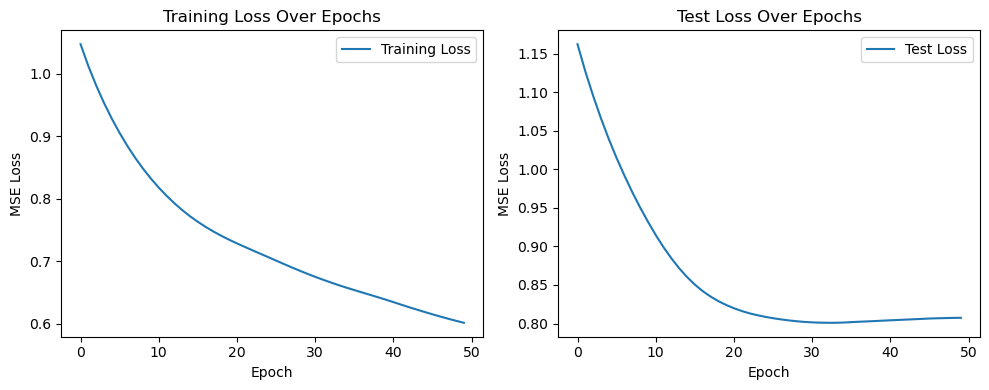

In [13]:
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # 테스트 손실 계산
    model.eval()
    with torch.no_grad():
        preds = model(X_test)
        test_loss = loss_fn(preds, y_test)
        test_losses.append(test_loss.item())

    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# 📈 Loss 시각화
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Test Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## 1. 기존 모델 문제점

- **과적합(Overfitting)** 조짐이 나타났다.  
  ➔ Train Loss는 꾸준히 감소하는데, Test Loss는 일정 시점 이후 오히려 증가하는 현상 발생
- **일반화 성능 저하**  
  ➔ 모델이 학습 데이터에는 과하게 잘 맞추지만, 새로운 데이터(Test set)에서는 성능이 떨어짐
- **모델이 너무 자유롭게 학습**  
  ➔ 모든 뉴런이 항상 활성화되어 훈련 데이터에만 최적화되는 문제 발생


## 2. 문제 해결을 위해 수행한 과정

- **Dropout 레이어 추가**
  - 은닉층에 Dropout(0.3) 적용 → 학습 중에 랜덤하게 뉴런의 일부를 끔
- **과적합 완화 시도**
  - Dropout으로 매 학습마다 다른 신경망 구조를 학습하도록 만들어 모델이 덜 민감하게 만듦
- **학습 안정성 향상**
  - Test Loss의 증가를 막고, 모델이 더 일반적인 패턴을 학습하도록 유도

Epoch 1/50, Train Loss: 1.0145, Test Loss: 1.0464
Epoch 5/50, Train Loss: 0.8487, Test Loss: 0.9432
Epoch 10/50, Train Loss: 0.8150, Test Loss: 0.8685
Epoch 15/50, Train Loss: 0.7633, Test Loss: 0.8204
Epoch 20/50, Train Loss: 0.7521, Test Loss: 0.7986
Epoch 25/50, Train Loss: 0.7323, Test Loss: 0.7869
Epoch 30/50, Train Loss: 0.7317, Test Loss: 0.7801
Epoch 35/50, Train Loss: 0.6906, Test Loss: 0.7759
Epoch 40/50, Train Loss: 0.6917, Test Loss: 0.7744
Epoch 45/50, Train Loss: 0.6527, Test Loss: 0.7727
Epoch 50/50, Train Loss: 0.6645, Test Loss: 0.7717


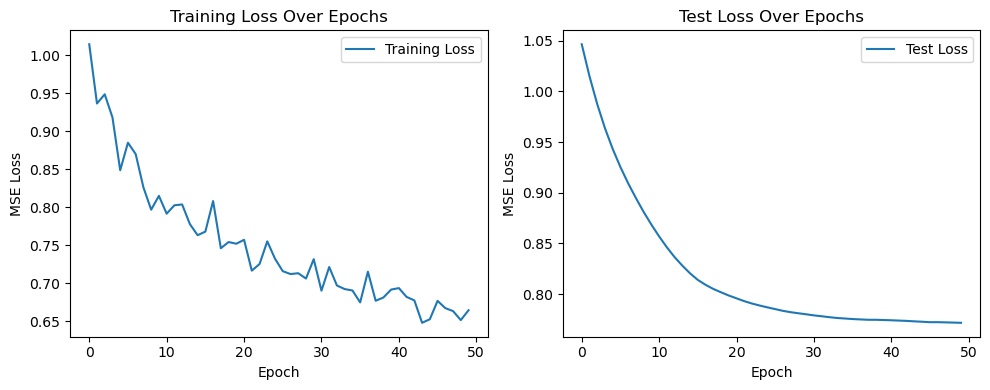

In [15]:
# 🏗️ 과적합 방지 모델 (Dropout 추가)
class RegularizedRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(7, 32)
        self.dropout = nn.Dropout(0.3)  # 30% 랜덤으로 꺼버림
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = RegularizedRegressionModel()

# 손실함수, 옵티마이저
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# 기록용 리스트
train_losses = []
test_losses = []

# 학습
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        preds = model(X_test)
        test_loss = loss_fn(preds, y_test)
        test_losses.append(test_loss.item())

    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

# 📈 Loss 시각화
plt.figure(figsize=(10, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot test loss
plt.subplot(1, 2, 2)
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Test Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## 3. 적용 결과

- **Training Loss**
  - Dropout 적용으로 인해 학습 과정이 약간 불안정(출렁거림)해졌지만 수렴 경향은 유지
- **Test Loss**
  - 꾸준히 부드럽게 감소하면서 과적합 현상 완화
- **일반화 성능 향상**
  - 훈련 데이터가 아닌 새로운 데이터에서도 성능이 유지되기 시작함

